# **CNN?**

🔹&nbsp;**신경망 구조, Neural Network**
-

사람의 뇌 구조에서 영감을 받아 만들어진 머신러닝 모델의 한 형태로, 다음 3가지의 레이어로 구성됩니다 :

- 입력층 (Input layer) : 예측에 필요한 정보를 입력받는 층
- 은닉층 (Hidden layer) : 여러 계산 노드(뉴런)가 연결되어 입력을 가공, 특징(Feature)을 추출하는 층
- 출력층 (Output layer) : 최종 예측 결과를 출력하는 층

이처럼 신경망은 입력값을 받아 여러 단계(레이어)를 거치는 계산 구조이며 그 깊이에 따라 단순한 문제부터 복잡한 문제까지 폭넓게 적용할 수 있습니다.

🔹&nbsp;**합성곱 신경망, Convolution Neural Network**
-

CNN은 이 신경망 구조를 기반으로 만들어졌으며, 이미지 처리에 특화된 계층 구조(합성곱, 풀링 등)를 도입했다는 점에서 일반 신경망과 구분됩니다.

기존 신경망은 이미지의 모든 픽셀을 한 줄로 펼쳐서 처리하기 때문에 그 형태나 공간을 반영하지 어렵다는 단점이 있습니다.

CNN은 이미지를 2차원 구조 그대로 유지하면서 형상, 패턴, 윤곽선 같은 중요한 시각적 특징을 자동으로 추출할 수 있습니다.

이러한 특징 덕분에 CNN은 이미지 분류, 얼굴 인식, 자율 주행, 의료 영상 분석 등 다양한 분야에서 폭넓게 활용되고 있습니다.

<img src="https://i.imgur.com/ManUgfq.jpeg" style="height:400px;">

# **1. 데이터 준비 및 전처리**

### 🔹 **데이터 전처리(Preprocessing)** 

모델 학습 전 데이터를 정리하고 가공하는 **모든 준비 과정**을 의미합니다. 
<br>이 작업은 모델이 데이터를 **정확하게 해석하고, 빠르게 수렴하며, 과적합 없이 일반화 성능을 확보**하는 데 핵심적인 역할을 합니다.

### 🔍 **주요 전처리 작업**

- 📦 **데이터 구조 정리** : 클래스별 폴더 정리, 라벨 CSV 작성, 경로 정리
- 🔀 **데이터 분할** : 학습 / 검증 / 테스트 세트로 구분
- 🔢 **수치적 변환** : 이미지 → Tensor 변환, 정규화, 크기 조정 등
- 🔧 **데이터 증강** : 회전, 뒤집기, 자르기 등 변형을 통해 데이터 다양화


### 🧮 **텐서, Tensor**
- PyTorch 에서 사용하는 **다차원 수치 배열 구조 (n차원 행렬)**
- 이미지 데이터는 일반적으로 **3차원 텐서** : [채널(색상), 높이(세로 픽셀), 너비(가로 픽셀)]
- 실제 CNN 학습 시에는 여러 장의 이미지를 한 번에 처리 → **배치(batch)** 차원이 추가된 [배치 크기, 채널, 높이, 너비] 형태의 **4차원 텐서** 사용

---

### 💼 **실무 관점**에서의 전처리
실무에서는 **정형화된 공개 데이터셋**보다 직접 수집한 **사용자 정의 데이터(Custom Dataset)** 를 다루는 경우가 많습니다.

이 경우 데이터셋은 다음과 같이 다양할 수 있습니다. 
- 📁 클래스별 폴더 분할 구조
- 📄 CSV 파일 기반 라벨링
- 🔀 파일 경로에 따른 라벨링

따라서 모델 입력 형태에 맞춰 유연하게 전처리 파이프라인을 구성하는 능력이 중요합니다.

# **1.1 단일 이미지 전처리**

PyTorch에서는 transforms 모듈을 통해 전처리를 체계적으로 적용할 수 있습니다.

### 🔹 **필수** 전처리 함수 : 모든 프로젝트에 **반드시** 사용
    
| 전처리 함수 | 설명 | 활용 |
|-------------|------|------|
| `transforms.Compose([...])` | 여러 전처리 작업을 순서대로 묶음 | 전처리 **파이프라인 구성**의 중심 축 역할 |
| `transforms.ToTensor()` | 이미지를 Tensor로 변환 + 0~1 스케일로 정규화 | 이미지 데이터를 **모델 입력 형식**으로 변환 |
| `transforms.Normalize(mean, std)` | 평균 0, 표준편차 1로 정규화 | 학습 **안정성 향상**, 수렴 속도 증가 |
| `transforms.Resize((H, W))` | 이미지를 주어진 크기로 통일 | 입력 크기 **일관성 확보** (모든 입력 동일 크기 보장) |

### ⚙️ **선택적** 전처리 함수 : 데이터 특성에 따라 **유동적**으로 활용

| 전처리 함수 | 설명 | 활용 |
|-------------|------|-----------|
| `transforms.RandomHorizontalFlip(p=0.5)` | 이미지 좌우 반전 (50% 확률) | 대칭 구조가 유효한 경우에 적합 |
| `transforms.RandomRotation(degrees)` | 일정 각도 내 무작위 회전 | 이미지의 기울어진 촬영에 대비 |
| `transforms.RandomCrop(size)` | 무작위 위치를 일정 크기로 잘라 사용 | 입력 다양성 확보, 주요 부분 학습 유도 |
| `transforms.ColorJitter(brightness=, contrast=, ...)` | 밝기, 대비, 채도 등의 색상 속성 조절 | 조명, 카메라 등 환경 변화에 강인함 확보 가능 |
| `transforms.RandomResizedCrop(size)` | 자르기 + 리사이즈를 동시에 수행 | 불균형한 배경 제거, 이미지 중심 영역 학습에 효과적 |
| `transforms.Grayscale(num_output_channels=1)` | 흑백으로 변환 | 색상이 중요하지 않거나, 1채널 입력만 필요한 경우 |

아래의 코드를 통해 한 장의 샘플 이미지에 전처리 함수를 적용해볼 수 있습니다.

100.0%


✅ 이미지 다운로드 완료: dog.jpg
💾 전처리된 이미지 저장 완료: dog_pre.jpg


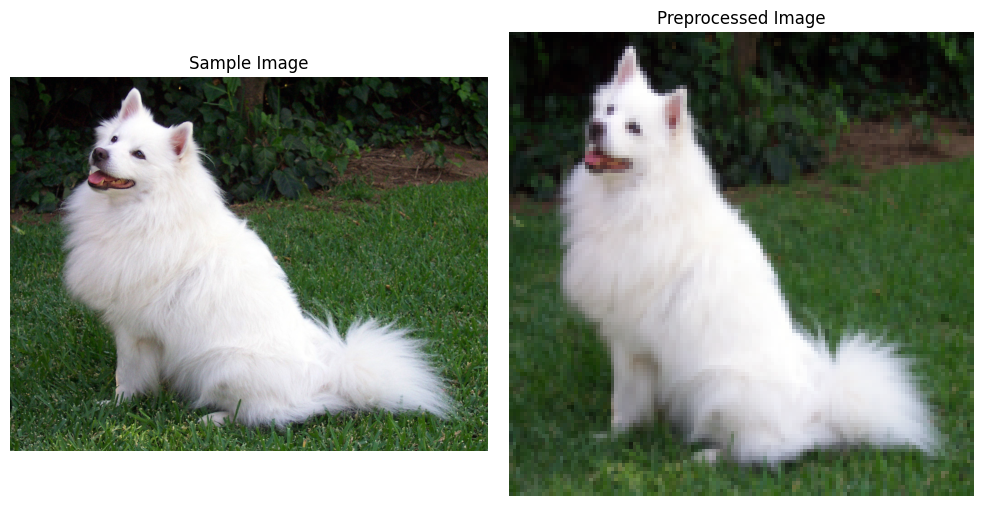

In [1]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets.utils import download_url
import torch

# ---------------------------------------
# 1. 경로 설정 및 폴더 생성
# ---------------------------------------
project_root = Path().resolve()                           # 현재 노트북 실행 경로
save_dir = project_root / "pre_sample"                    # 이미지 저장 디렉토리
save_dir.mkdir(parents=True, exist_ok=True)               # 폴더 없으면 자동 생성

image_path = save_dir / "dog.jpg"                         # 원본 이미지 저장 경로
output_image_path = save_dir / "dog_pre.jpg"              # 전처리 이미지 저장 경로

# ---------------------------------------
# 2. torchvision 샘플 이미지 다운로드
# ---------------------------------------
url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
if not image_path.exists():
    download_url(url, root=save_dir, filename="dog.jpg")
    print("✅ 이미지 다운로드 완료:", image_path.name)
else:
    print("✅ 이미지 이미 존재함:", image_path.name)

# ---------------------------------------
# 3. 전처리 정의
# ---------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),                     # 이미지 크기 통일
    transforms.RandomHorizontalFlip(p=0.5),            # 좌우 반전 (50% 확률)
    transforms.ToTensor(),                             # [0~255] → [0~1] 실수형 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5),              # R, G, B 각각 평균 0.5로 정규화
                         (0.5, 0.5, 0.5))
])

# ---------------------------------------
# 4. 이미지 불러오기 및 전처리 적용
# ---------------------------------------
original_img = Image.open(image_path).convert("RGB")
processed_tensor = transform(original_img)

# ---------------------------------------
# 5. 정규화 해제 함수 (시각화를 위해)
# ---------------------------------------
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

processed_for_plot = denormalize(processed_tensor.clone(), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

# ---------------------------------------
# 6. 전처리 후 이미지 저장 (항상 덮어쓰기)
# ---------------------------------------
# tensor → PIL 이미지 변환 후 저장
to_pil = transforms.ToPILImage()
preprocessed_img = to_pil(processed_for_plot)
preprocessed_img.save(output_image_path)
print("💾 전처리된 이미지 저장 완료:", output_image_path.name)

# ---------------------------------------
# 7. 전처리 전/후 이미지 시각화
# ---------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_img)
axs[0].set_title("Sample Image")
axs[0].axis("off")

axs[1].imshow(processed_for_plot.permute(1, 2, 0))  # [C, H, W] → [H, W, C]
axs[1].set_title("Preprocessed Image")
axs[1].axis("off")

plt.tight_layout()
plt.show()

# **1.2 폴더 구조 기반 데이터셋 전처리**

앞서 torchvision의 샘플 이미지를 통해 단일 이미지에 대한 전처리 실습을 진행해 보았습니다. 

이번에는 클래스별 하위 폴더 구조를 가진 **폴더 기반 데이터셋**을 사용하는 경우 어떻게 전처리 작업을 진행하는지 알아보겠습니다.

💾 폴더 기반 데이터셋 예시 :

cnn_edu/<br>
└── data_folder/<br>
&emsp;&emsp;&emsp;├── dog/<br>
&emsp;&emsp;&emsp;│&emsp;&emsp;├── dog1.jpg<br>
&emsp;&emsp;&emsp;│&emsp;&emsp;├── dog2.jpg<br>
&emsp;&emsp;&emsp;└── cat/<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;├── cat1.jpg<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;├── cat2.jpg

### 📁 **폴더 기반 데이터셋** 전처리 함수

| 함수 | 설명 | 활용 |
|------------------------------|-----------------------------------------------------|------------------------------------------------|
| `ImageFolder(root, transform=...)` | 폴더 구조를 기반으로 자동 라벨링 (서브폴더명을 클래스로 인식) | 폴더 기반 데이터셋을 쉽게 불러올 때 사용 |
| `os.makedirs(path, exist_ok=True)` | 지정한 경로에 폴더 생성. 중복 시 오류 없이 패스 | 폴더 자동 생성 시 유용 |
| `os.listdir(path)` | 특정 디렉토리 내 파일 및 폴더 목록 확인 | 클래스 폴더 구조 점검 및 탐색 등에 활용 |
| `splitfolders.ratio(...)` | 클래스별 이미지 폴더를 자동 분할 | 데이터셋 분류를 자동화할 때 사용 |

### 📦 **DataLoader**: 전처리된 데이터를 모델에 전달하는 배치 공급 장치

전처리가 완료된 데이터셋은 모델 학습을 위해 효율적으로 배치 처리되어야 합니다. 이때 사용하는 도구가 DataLoader입니다.

DataLoader는 **전처리 및 구조화가 끝난 데이터셋**을 학습에 사용할 수 있도록 **배치 단위로 분할**하고, **셔플**, **병렬 로딩**까지 수행해주는 PyTorch의 데이터 공급 도구입니다.

| 구성 요소 | 설명 | 예시 |
|-----------|------|------|
| `dataset` | `ImageFolder` 등 전처리된 데이터셋 객체 | `ImageFolder("data/train", transform=...)` |
| `batch_size` | 한 번에 모델에 전달할 데이터 수 | `32` |
| `shuffle` | 매 epoch마다 데이터 순서를 섞을지 여부 | `True` (학습용에 권장) |
| `num_workers` | 데이터를 병렬로 불러올 subprocess 수 | `2~4` (CPU 코어 수에 따라 설정) |

아래의 코드를 통해 폴더 구조 데이터셋을 자동으로 업로드 및 압축 해제하고, 전처리 작업을 통해 학습에 사용 가능한 구조로 변환시킬 수 있습니다.


In [14]:
import requests
import zipfile
import os

# 1. GitHub Release에서 data_folder.zip 다운로드 및 압축 해제
url = "https://github.com/RML-KSJ/MachineLearning_EDU/releases/download/CNN_release-2025/data_folder.zip"

# 다운로드
with open("data_folder.zip", "wb") as f:
    f.write(requests.get(url).content)

# 압축 해제
with zipfile.ZipFile("data_folder.zip", "r") as zip_ref:
    zip_ref.extractall("data_folder")

# 결과 확인
print("✅ 압축 해제 완료")
print("📁 폴더 내 파일 목록:", os.listdir("data_folder"))

# 2. 데이터 분할 (학습 80%, 검증 20%)
import splitfolders

splitfolders.ratio(
    input="data_folder", 
    output="data_folder_split", 
    seed=42, 
    ratio=(.8, .2)  # 학습 80%, 검증 20%
)

print("✅ 학습/검증 데이터 분할 완료")
print("📁 data_folder_split 폴더 구조:", os.listdir("data_folder_split"))


# 3. ImageFolder + 전처리 + DataLoader 구성
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 이미지 전처리 파이프라인
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# ImageFolder를 활용한 데이터 로딩
train_dataset = datasets.ImageFolder("data_folder_split/train", transform=transform)
val_dataset   = datasets.ImageFolder("data_folder_split/val", transform=transform)

# DataLoader 구성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 확인
print("✅ 전처리 및 로딩 완료")
print("📚 클래스 목록:", train_dataset.classes)


✅ 압축 해제 완료
📁 폴더 내 파일 목록: ['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']
✅ 학습/검증 데이터 분할 완료
📁 data_folder_split 폴더 구조: ['train', 'val']
✅ 전처리 및 로딩 완료
📚 클래스 목록: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# **1.3 복잡 구조 데이터셋 전처리**

실무 환경에서는 보통 이미지와 라벨이 분리되거나 구조가 복잡한 **사용자 정의 데이터(Custom Dataset)** 를 다루게 됩니다.

따라서 목적에 맞게 데이터를 유연하게 불러오고 전처리하는 능력이 필요합니다.

### 📌 **복잡한 데이터 구조?**

- 📦 이미지와 라벨이 **분리된** 구조 : 이미지 파일은 한 폴더에 몰려 있고, 라벨 정보는 별도의 CSV, JSON 등에 존재 → 해당 파일에서 라벨을 읽어들일 필요
- 🏷 라벨이 숫자가 아닌 **문자열** : "dog", "cat" 등 문자열로 표시된 경우 → 인덱스 변환 필요
- 🔀 경로가 **불규칙적**이거나 **중첩** : 하위 디렉토리가 여러 단계 존재하거나 경로명이 불명확 → 경로를 고려한 추가적인 작업 필요


| 함수 | 설명 | 활용 |
|------------------------------------|--------------------------------------------------|-------------------------------------|
| `pandas.read_csv()`                | 라벨이 담긴 CSV 파일 읽기                        | 이미지-레이블 매핑 테이블 생성     |
| `os.path.join()`                   | 파일 경로 합성                                   | 이미지 전체 경로 만들기            |
| `PIL.Image.open()` 또는 `cv2.imread()` | 이미지 파일 열기                                | 이미지 불러오기                    |
| `sklearn.preprocessing.LabelEncoder`| 문자열 라벨 → 정수 인코딩                        | 클래스 인덱스 정리                  |
| `torch.utils.data.Dataset`         | PyTorch 커스텀 Dataset 클래스 상속               | 복잡한 전처리 및 로딩 직접 정의    |
| `transform(image)`                 | torchvision 전처리 파이프라인 적용               | Resize, Normalize 등 변환 수행     |

사용할 데이터셋 **data_csv.zip** 파일은 **Masked MS-COCO Dataset**을 일부 재구성한 것으로, 해당 데이터셋에는 하나의 CSV 파일 내에 다음의 내용이 들어있습니다. 
- image_name : 이미지 파일 이름
- label : 라벨 클래스 번호
- semantic_label : 문자열 라벨 클래스 명
- partition : 데이터 분할 (train/val)

아래의 코드에선 전처리 실습 뿐만 아니라 이미지 파일 총 25000장을 5000장으로 줄이는 샘플링 실습 또한 진행할 수 있습니다. 

In [13]:
import os, zipfile, shutil
import requests
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 1. GitHub Release에서 data_csv.zip 다운로드 및 압축 해제
url = "https://github.com/RML-KSJ/MachineLearning_EDU/releases/download/CNN_release-2025/data_csv.zip"

with open("data_csv.zip", "wb") as f:
    f.write(requests.get(url).content)

with zipfile.ZipFile("data_csv.zip", 'r') as zip_ref:
    zip_ref.extractall("data_csv")

print("✅ 압축 해제 완료")
print("📁 폴더 내 파일 목록:", os.listdir("data_csv"))

# 2. CSV 불러오기 및 열 이름 정리
df = pd.read_csv("data_csv/train_val.csv")
df.columns = df.columns.str.strip()
df = df.rename(columns={"image_name": "filename", "partition": "split"})

# 3. 문자열 라벨을 정수 인덱스로 변환
le = LabelEncoder()
df['label'] = df['label'].astype(str)
df['label_idx'] = le.fit_transform(df['label'])

# 4. 클래스별 균등 샘플링 (총 5,000장: 학습 4,000 / 검증 1,000)
n_train, n_val = 4000, 1000
n_classes = df['label_idx'].nunique()
train_per_class = n_train // n_classes
val_per_class = n_val // n_classes

train_df = df[df['split'] == 'train'].groupby('label_idx', group_keys=False).sample(n=train_per_class, random_state=42)
val_df   = df[df['split'] == 'val'].groupby('label_idx', group_keys=False).sample(n=val_per_class, random_state=42)
df_sampled = pd.concat([train_df, val_df]).reset_index(drop=True)

# 5. 이미지와 마스크를 별도 폴더로 복사
img_src, mask_src = "data_csv/images", "data_csv/masks"
img_dst, mask_dst = "data_csv/images_sampled", "data_csv/masks_sampled"
os.makedirs(img_dst, exist_ok=True)
os.makedirs(mask_dst, exist_ok=True)

for fname in df_sampled['filename']:
    shutil.copy(os.path.join(img_src, fname), os.path.join(img_dst, fname))
    shutil.copy(os.path.join(mask_src, fname), os.path.join(mask_dst, fname))

print("✅ 샘플링 이미지 복사 완료")
print("📊 클래스 수:", n_classes)
print("🖼️ 총 이미지 수:", len(df_sampled))

# 6. 전처리 파이프라인 정의
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 7. 사용자 정의 Dataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.img_dir, row['filename'])).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, row['label_idx']

# 8. Dataset 및 DataLoader 구성
train_dataset = CustomDataset(train_df, img_dst, transform)
val_dataset   = CustomDataset(val_df, img_dst, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("✅ DataLoader 구성 완료")

✅ 압축 해제 완료
📁 폴더 내 파일 목록: ['images', 'masks', 'train_val.csv']
✅ 샘플링 이미지 복사 완료
📊 클래스 수: 10
🖼️ 총 이미지 수: 5000
✅ DataLoader 구성 완료


# **2. 모델 아키텍처 구성**

학습에 사용할 데이터를 모두 준비 완료하였습니다. 이제 이를 학습할 CNN 모델을 설정해 보겠습니다.

### 🧱 CNN 모델 아키텍처의 **기본 구성 요소**

1. **Convolution Layer (합성곱 계층)**

   - 입력 이미지 위를 **작은 필터(커널, kernel)** 가 **슬라이딩**하며 **특징(feature)** 추출
  
   - 각각의 필터는 특정 종류의 피처를 감지 (엣지, 패턴 등)
  
2. **Activation Function (활성화 함수)**

   - 각 층의 출력값에 **비선형성을 부여**하여 복잡한 패턴을 학습할 수 있게 만듦

   - 가장 널리 쓰이는 예시는 **ReLU (Rectified Linear Unit)**:  
     수식 𝑓(𝑥) = max(0, 𝑥) → 음수 제거, 양수 유지

   - 그 외에도 **LeakyReLU, Tanh, Sigmoid, GELU, SiLU** 등 다양한 함수가 사용될 수 있음

   - 주로 **합성곱 계층** 과 **완전연결층** 뒤에 배치
  
3. **Pooling Layer (풀링 계층)**

   - 각 계층 영역에서 사용자의 설정에 따라 **최댓값(MaxPooling)** 또는 **평균값(AveragePooling)** 등을 선택

   - 피처 맵의 크기를 줄이고 **중요한 정보만 유지**
  
   - 같은 물체가 이미지의 다른 위치에 있더라도 핵심 특징만 남겨 **위치 변화에도 강인함 확보**

4. **Flatten** 

   - 합성곱 계층이 추출한 **2D 피처 맵**을 **1D 벡터** 형태로 펼침

   - 완전 연결층 FC의 입력으로 사용

5. **Fully Connected Layer (완전 연결층, FC)**

   - Flatten된 특징 벡터를 받아 출력 클래스 수에 맞게 **점수 계산**

   - 모든 노드를 연결해 **최종 분류** 수행

### 🔍 CNN 레이어 흐름 정리

```text
입력 이미지 Tensor (예: batch=16, RGB=3, 32x32 이미지 파일 → [16, 3, 32, 32])
 ↓
[Conv + 활성화 함수] → 특징 추출
 ↓
[Pooling] → 중요 특징 유지 + 연산 축소
 ↓
[Conv + 활성화 함수 + Pooling] → 여러 계층을 반복 (깊이 증가)
 ↓
[Flatten] → 2D 피처 맵을 1D 벡터로 변환
 ↓
[Fully Connected Layer + 활성화 함수] → 각 클래스에 대한 점수 계산
 ↓
출력
```
이처럼 CNN은 입력 이미지를 계층적으로 처리하며, 점점 고차원의 복잡한 특징을 추출하여 최종 분류를 수행할 수 있도록 합니다.


# **2.1 CNN 계층 설계**

### 🧩 하이퍼파라미터란?

모델을 만들 때에는 사람이 **직접 설정해주는 값**이 있습니다.  
이러한 값들을 **하이퍼파라미터(hyperparameter)** 라고 부릅니다.

- 모델이 **학습하면서 자동으로 찾는 값**은 '가중치(weight)'  
- 반면, 사람이 **미리 설정해줘야 하는 값**은 '하이퍼파라미터'

즉, 하이퍼파라미터는 **모델의 구조와 동작 방식을 결정하는 설정값**이라 할 수 있습니다.

---

### 🧱 CNN에서 중요한 하이퍼파라미터
<br>

🔹**합성곱 계층(Conv2d)**

| 항목 | 예시 | 의미 | 모델에 미치는 영향 |
|------|------|------|-------------------|
| 입력 채널 수 (`in_channels`) | 3 | 입력 이미지의 색상 채널 수 (흑백:1, RGB:3) | 입력 데이터 형식을 정의 |
| 출력 채널 수 (`out_channels`) | 16 | 필터 개수 ( = 추출할 특징 종류 수) | 값이 크면 모델 표현력과 파라미터 수 증가, 연산량 증가 |
| 필터 크기 (`kernel_size`) | 3 | 합성곱 영역의 크기 (예: 3x3) | 작을수록 세밀한 특징, 클수록 넓은 구조 감지 |
| 스트라이드 (`stride`) | 1 | 합성곱 필터 이동 간격 | 출력 크기 축소, 연산량 감소 |
| 패딩 (`padding`) | 1 | 입력 가장자리에 0을 추가해 크기 유지 | 출력 크기를 입력과 맞추거나, 정보 손실 방지 목적 |
| 활성화 함수 | ReLU 등 | 출력값에 비선형성을 부여 | 복잡한 패턴 학습 가능 |

<br>

🔹**풀링 계층(Pool2d)**

| 항목 | 예시 | 의미 | 모델에 미치는 영향 |
|------|------|------|-------------------|
| 풀링 종류 | Max / Average | 대표값을 선택하는 방식 결정 | Max : 뚜렷한 특징 강조 / Average : 전체 정보를 부드럽게 요약 |
| 필터 크기 (`kernel_size`) | 2 | 풀링할 영역의 크기 (예: 2x2) | 큰 크기는 더 넓은 영역을 요약하여 출력 크기 감소 |
| 스트라이드 (`stride`) | 2 | 풀링 필터 이동 간격 | 출력 크기와 요약 정도 결정. 크면 정보 압축률이 높아짐 |
| 패딩 (`padding`) | 0 | 입력 가장자리에 0을 추가해 크기 유지 | 거의 사용하지 않음. 출력 크기 보정 시 예외적으로 사용됨 |

<br>

🔹**Flatten 계층**

- 파라미터는 없지만, 뒤에 연결될 완전 연결층의 입력 크기를 결정

- 출력 크기 계산 이후 반드시 등장하는 구조 : 모든 값을 곱해 1D 값으로 변환
<br>

🔹 **완전 연결층 (Fully Connected, FC)**

| 항목 | 예시 | 의미 | 모델에 미치는 영향 |
|------|------|------|-------------------|
| 입력 피처 수 (`in_features`) | 2048 | Flatten 결과의 길이 (Flatten 계층의 출력 크기) | 정확히 일치하지 않으면 오류 발생 |
| 출력 피처 수 (`out_features`) | 10 | 분류할 클래스 수 또는 중간 노드 수 | 클래스 수에 따라 출력 크기 결정, 분류 성능 및 모델 복잡도에 영향 |
| 활성화 함수 | ReLU 등 | 출력값에 비선형성을 부여 | 학습 가능한 복잡한 패턴 표현, 분류 결과 해석에 영향 |


---

### 🔍 예시 코드

```python
nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(32 * 8 * 8, 128), # 첫 번째 FC: Flatten된 특징을 128차원으로 변환 (은닉층)
    nn.ReLU(),
    nn.Linear(128, 10) # 두 번째 FC: 10개의 클래스에 대한 최종 점수 출력 (출력층)
)


# **2.2 출력 크기 계산**

입력 이미지는 **합성곱 계층(Conv2d)** 과 **풀링 계층(Pool2d)** 을 통과할 때마다, 각 계층의 설정에 따라 출력 크기가 달라집니다.

### 🧮 출력 크기 계산식
#### $H_{out} = \left\lfloor \frac{H_{in} + 2P_H - K_H}{S_H} \right\rfloor + 1$

#### $W_{out} = \left\lfloor \frac{W_{in} + 2P_W - K_W}{S_W} \right\rfloor + 1$

- $H_{in}, W_{in}$ : 입력 이미지의 높이 / 너비  
- $K_H, K_W$ : 필터(커널)의 높이 / 너비  
- $S_H, S_W$ : 스트라이드 (높이/너비 방향 이동 간격)  
- $P_H, P_W$ : 패딩 (상하/좌우 여백)   

#### 🧪 **예시: 입력 이미지 크기 [3, 128, 96] , 2계층 CNN**

2계층 CNN 구성:

**#1**  
1️⃣ Conv2d(3, 16, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1)  
2️⃣ MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

**#2**  
1️⃣ Conv2d(16, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))  
2️⃣ MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

**#3**  
1️⃣ Flatten()  
2️⃣ Linear(32 × 32 × 24, 128)  
3️⃣ Linear(128, 10) → 최종 출력

| 계층           | 입력 크기       | 커널 / 스트라이드 / 패딩 | 계산식                                                                 | 출력 크기     | 채널 변화   |
|----------------|------------------|----------------------------|--------------------------------------------------------------------------|----------------|----------------|
| Conv2d  #1-1    | 128 × 96         | 5×3 / 1×1 / 2×1            | H: (128 + 2×2 − 5)/1 + 1 = **128**<br>W: (96 + 2×1 − 3)/1 + 1 = **96**  | 128 × 96       | 3 → 16         |
| MaxPool #1-2    | 128 × 96         | 2×2 / 2×2 / 0×0            | H: (128 − 2)/2 + 1 = **64**<br>W: (96 − 2)/2 + 1 = **48**               | 64 × 48        | 16 → 16        |
| Conv2d  #2-1    | 64 × 48          | 3×5 / 1×1 / 1×2            | H: (64 + 2×1 − 3)/1 + 1 = **64**<br>W: (48 + 2×2 − 5)/1 + 1 = **48**    | 64 × 48        | 16 → 32        |
| MaxPool #2-2    | 64 × 48          | 2×2 / 2×2 / 0×0            | H: (64 − 2)/2 + 1 = **32**<br>W: (48 − 2)/2 + 1 = **24**                | 32 × 24        | 32 → 32        |
| Flatten #3-1    | [32, 32, 24]     | -                          | 32 × 32 × 24 = **24576**                                                | 24576          | -              |
| Linear  #3-2    | 24576            | -                          | 24576 → **128**                                                             | 128            | 24576 → 128    |
| Linear  #3-3    | 128              | -                          | 128 → **10**                                                                | 10             | 128 → 10       |


최종 출력 : **[10]** 개의 클래스에 대한 점수


# **3. 계층 흐름 분석**

앞선 2장 모델 아키텍처 구성에서 CNN 모델 아키텍처를 설계하고 출력 크기 계산 실습을 완료했습니다.

본격적인 모델 학습 전에, 여러 이미지를 통과시켜 **계층별 출력(Feature Map)을 시각화**하여 CNN의 작동 원리를 확인해보겠습니다.

아래의 코드는 1.2장에서 실습한 폴더 구조 기반 데이터셋의 5개 클래스에서 각각 1장씩 이미지를 불러와 CNN 계층을 통과시킨 후 Feature Map을 시각화합니다.

CNN 계층의 커널 크기, 스트라이드, 패딩 등 하이퍼파라미터 값을 변경해가며 각 값이 Feature Map에 어떤 변화를 주는지 직접 확인해볼 수 있습니다.

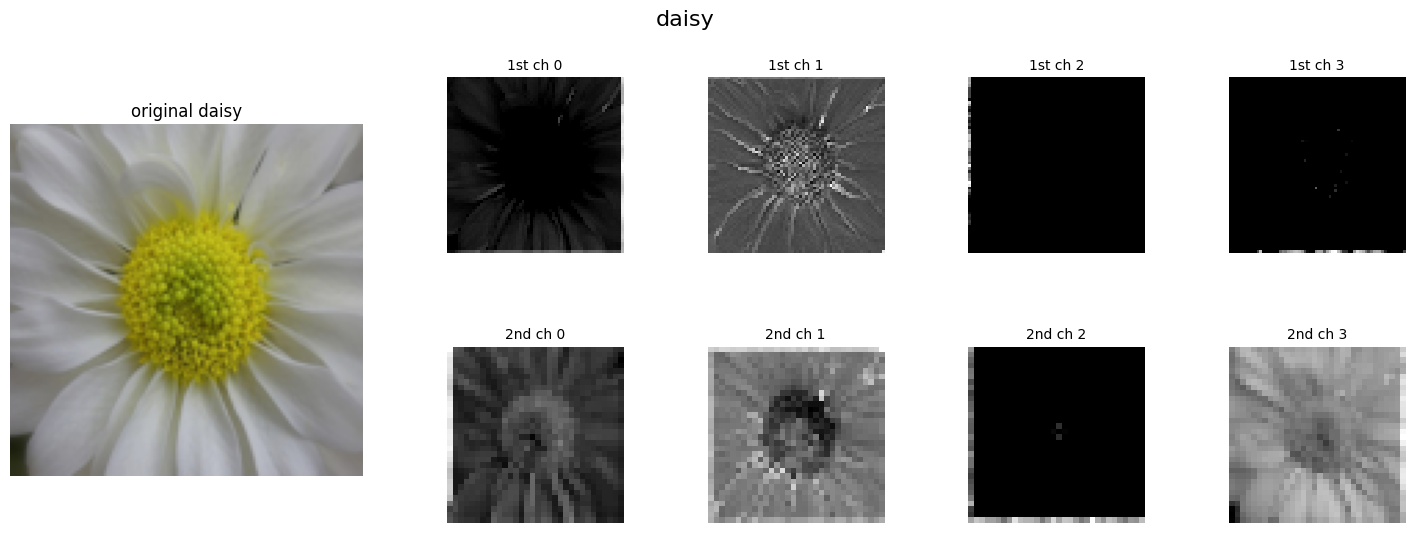

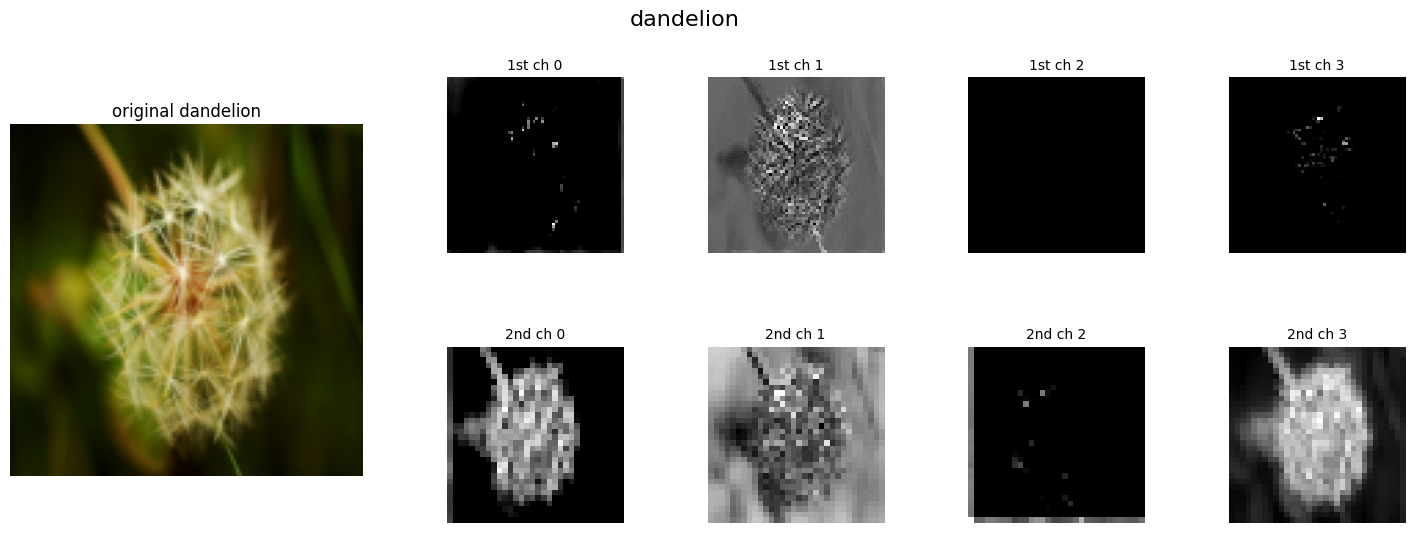

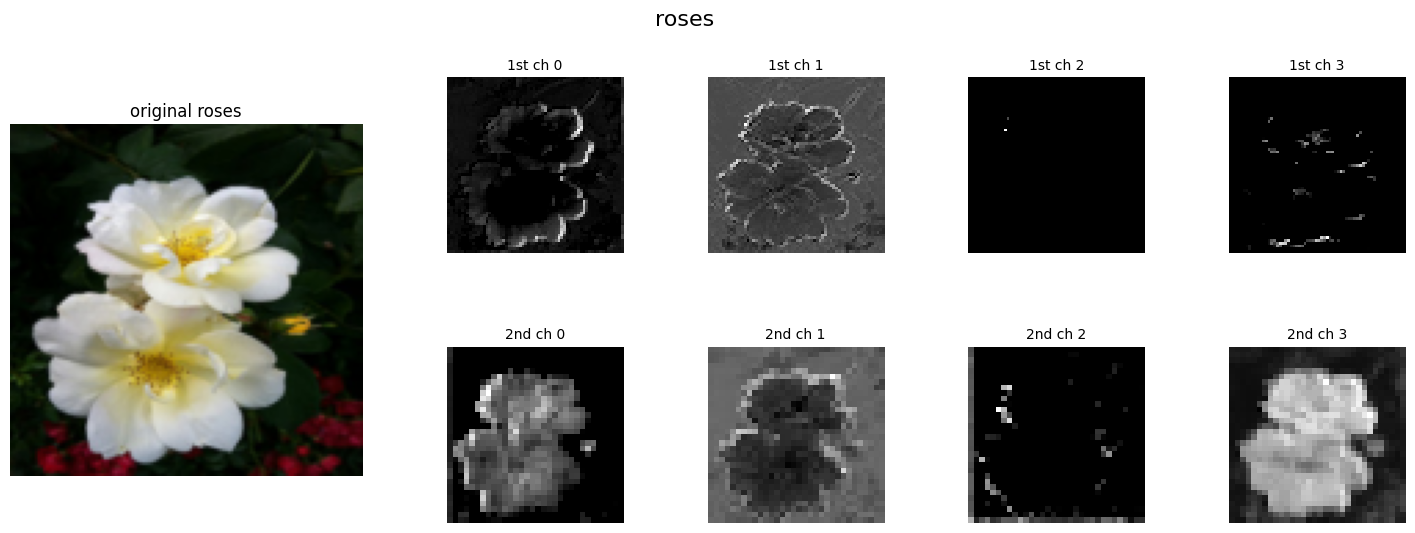

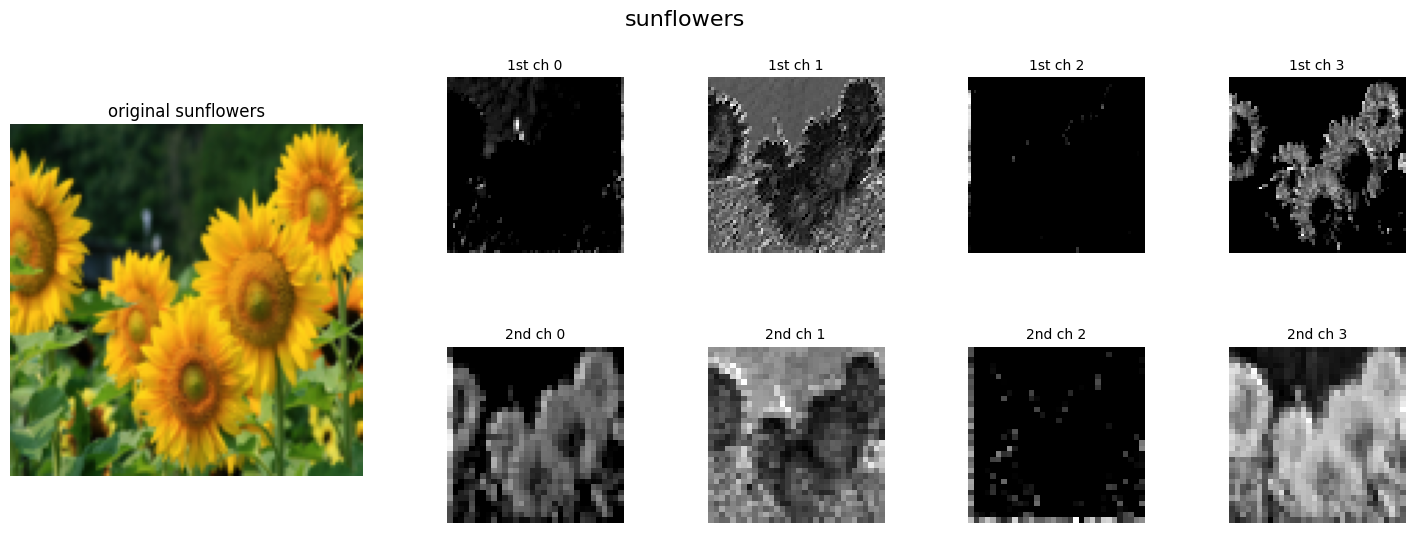

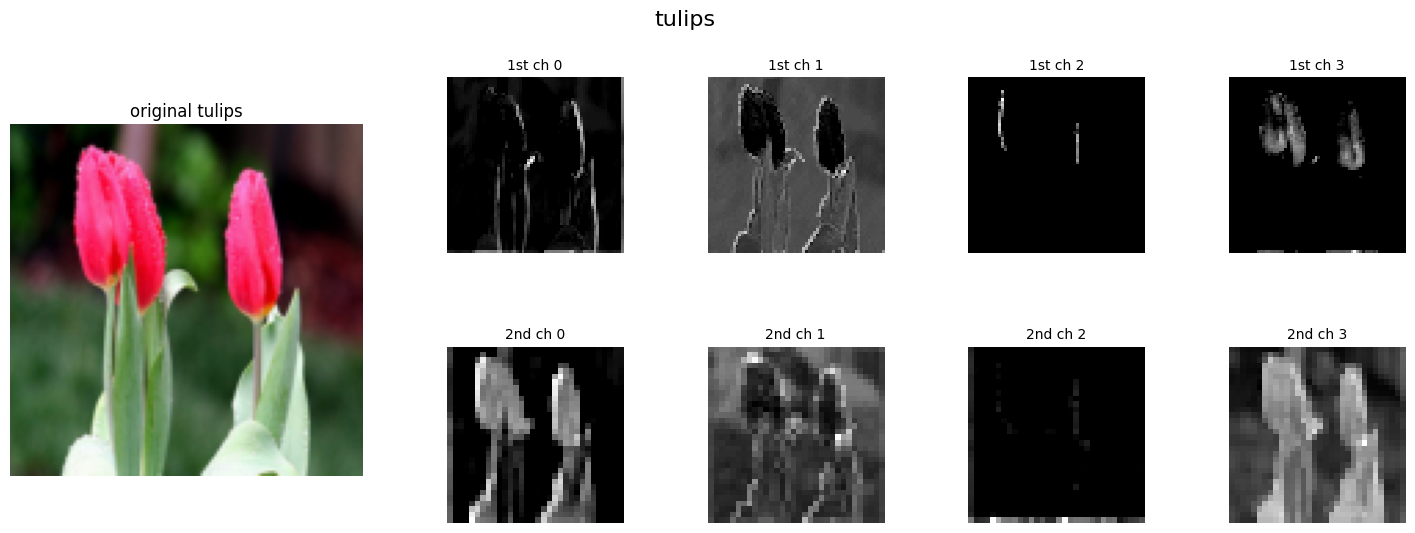

In [24]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from matplotlib import gridspec

# 1. CNN 모델 정의 (Conv1, Conv2 출력을 모두 반환)
# - 각 계층의 출력을 따로 받아서 시각화 가능
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):  # 입력 이미지를 CNN 계층에 통과시켜 Feature Map을 반환
        out1 = self.conv1(x)  # 첫 번째 합성곱 계층 출력
        out2 = self.conv2(out1)  # 두 번째 합성곱 계층 출력
        return out1, out2

# 모델 준비 (평가 모드: 학습 관련 기능 비활성화)
model = SimpleCNN()
model.eval()

# 2. 전처리 정의
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 크기를 128x128로 통일
    transforms.ToTensor()           # 이미지를 Tensor로 변환 (0~1 범위)
])

# 3. 데이터셋 로딩
dataset = datasets.ImageFolder("data_folder_split/train", transform=transform)
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# 4. 각 클래스에서 1장씩 선택
samples_per_class = 1
selected_indices = []
for class_idx in range(len(class_to_idx)):
    class_indices = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    selected_indices.extend(class_indices[:samples_per_class])

subset = Subset(dataset, selected_indices)

# 5. 배치 로딩
subset_loader = DataLoader(subset, batch_size=len(selected_indices), shuffle=False)
images, labels = next(iter(subset_loader))

# 6. CNN 통과
# - torch.no_grad(): 학습에 필요한 기울기 계산을 생략 → 속도 향상, 메모리 절약
with torch.no_grad():
    conv1_maps, conv2_maps = model(images)

# 7. 시각화
max_channels_to_show = 4
for i in range(len(images)):
    label_name = idx_to_class[labels[i].item()]

    fig = plt.figure(figsize=(3 * (max_channels_to_show + 2), 6))
    gs = gridspec.GridSpec(2, max_channels_to_show + 1, width_ratios=[2] + [1]*max_channels_to_show)

    # 원본 이미지 배치
    ax_orig = plt.subplot(gs[:, 0])
    ax_orig.imshow(images[i].permute(1, 2, 0))
    ax_orig.set_title(f"original {label_name}", fontsize=12)
    ax_orig.axis('off')

    # 첫 번째 행: Conv1 Feature Map
    for c in range(max_channels_to_show):
        ax = plt.subplot(gs[0, c+1])
        ax.imshow(conv1_maps[i][c], cmap='gray', interpolation='nearest')
        ax.set_title(f"1st ch {c}", fontsize=10)
        ax.axis('off')

    # 두 번째 행: Conv2 Feature Map
    for c in range(max_channels_to_show):
        ax = plt.subplot(gs[1, c+1])
        ax.imshow(conv2_maps[i][c], cmap='gray', interpolation='nearest')
        ax.set_title(f"2nd ch {c}", fontsize=10)
        ax.axis('off')

    fig.suptitle(f"{label_name}", fontsize=16)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

# **4. 모델 학습**